# Machine Learning Engineer Nanodegree
## Reinforcement Learning
## Project: Train a Smartcab to Drive


-----

## Getting Started
In this project, I will work towards constructing an optimized Q-Learning driving agent that will navigate a *Smartcab* through its environment towards a goal. Since the *Smartcab* is expected to drive passengers from one location to another, the driving agent will be evaluated on two very important metrics: **Safety** and **Reliability**. A driving agent that gets the *Smartcab* to its destination while running red lights or narrowly avoiding accidents would be considered **unsafe**. Similarly, a driving agent that frequently fails to reach the destination in time would be considered **unreliable**. Maximizing the driving agent's **safety** and **reliability** would ensure that *Smartcabs* have a permanent place in the transportation industry.

**Safety** and **Reliability** are measured using a letter-grade system as follows:

| Grade 	| Safety 	| Reliability 	|
|:-----:	|:------:	|:-----------:	|
|   A+  	|  Agent commits no traffic violations,<br/>and always chooses the correct action. | Agent reaches the destination in time<br />for 100% of trips. |
|   A   	|  Agent commits few minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 90% of trips. |
|   B   	| Agent commits frequent minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 80% of trips. |
|   C   	|  Agent commits at least one major traffic violation,<br/> such as driving through a red light. | Agent reaches the destination on time<br />for at least 70% of trips. |
|   D   	| Agent causes at least one minor accident,<br/> such as turning left on green with oncoming traffic.       	| Agent reaches the destination on time<br />for at least 60% of trips. |
|   F   	|  Agent causes at least one major accident,<br />such as driving through a red light with cross-traffic.      	| Agent fails to reach the destination on time<br />for at least 60% of trips. |

To assist evaluating these important metrics, the visualization code is imported through the code cell below. 

In [1]:
# Import the visualization code
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

### Understand the World
Before starting to work on implementing your driving agent, it's necessary to first understand the world (environment) which the *Smartcab* and driving agent work in. To begin, simply run the `agent.py` agent code and observe the **white vehicle** which is the *Smartcab*. The smartcab does not move at all during the simulation. The smartcar receives rewards when the traffic light infront of it turns to red. And the smartcar gets punished when the light turns to green. 




### Understand the Code
In the `/smartcab/` top-level directory, there are two folders: `/logs/` (which will be used later) and `/smartcab/`. Open the `/smartcab/` folder and explore each Python file to understand the code itself that governs the simulation. In the agent.py Python file, learning, epsilon, and alpha are chosen as three flags. If the learning is true, then the agent is forced to use Q-learning, otherwise, the agent just drives randomly without learning. The epsilon controls how much the agent explore the enviroment, the smaller the epsilon is, the less exploration egent will go through. Learning rate more towards 1 means the agent learns faster. Act class function is called when an agent performs an action in environment.py. In the simulator.py, 'render()' is using GUI to display the simulation . 'render_text()' is for supplementary trial data with non-GUI simulation. In the planner.py, the 'next_waypoint()' function will consider if the agent is on the right direction, then continue. It will consider the East-West direction first, and the make judgment on North-South.


-----
## Implement a Basic Driving Agent

The first step to creating an optimized Q-Learning driving agent is getting the agent to actually take valid actions. In this case, a valid action is one of `None`, (do nothing) `'left'` (turn left), `right'` (turn right), or `'forward'` (go forward). The first implementation is to navigate to the `'choose_action()'` agent function and to make the driving agent randomly choose one of these actions. 

### Basic Agent Simulation Results
To obtain results from the initial simulation, the following flags are adjusted:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.

The visual simulation (which can make the trials go faster) is disable by setting the `'display'` flag to `False`. The code cell below is run to visualize the results after successfully completing the initial simulation. 


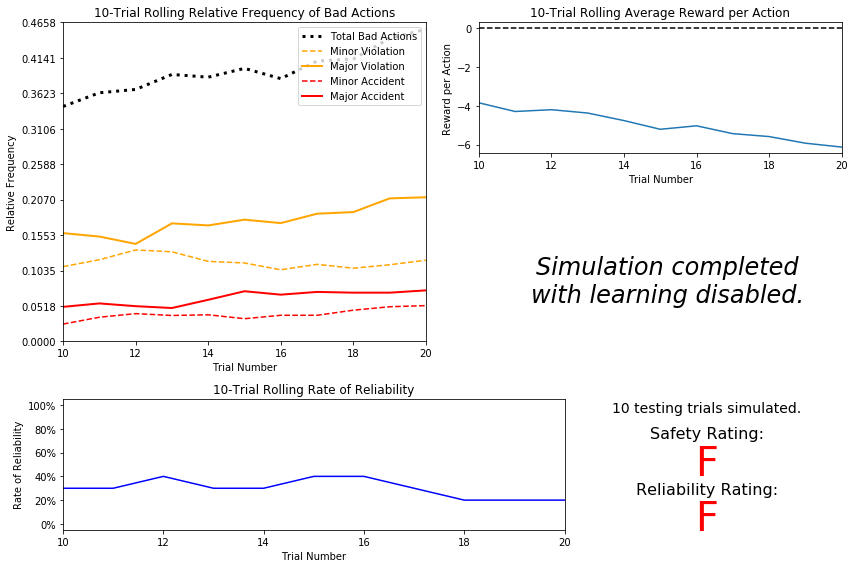

In [23]:
# Load the 'sim_no-learning' log file from the initial simulation results
vs.plot_trials('sim_no-learning.csv')

### Results Observation
For all trial numbers, nearly half of the time, the agent makes bad decision. In these bad decision, 1/8 of the time, these bad decisions cause accidents. Considering the agent is driving randomly, this 40% bad decisions rate makes a lot of sense. The agent receives negative rewards with minimum of -6 for its overall actions. It suggests that the agent has been penalized very light. Accident is a huge safety fall pit for self-driving cars, the accident and other safety violation should be penalized heavily. From the figure of "10-Trial Rolling Rate of Reliability", there is some variation due to the randomness, but overall the agent is not learning at all. The results are roughly the same over the trials. Therefore, this smartcab should be considered dangerous for its passengers since the accident rate of a human driver should be far below 40%. 

-----
## Inform the Driving Agent
The second step is to create an optimized Q-learning driving agent. Depending on the input, sensory data, and additional variables available to the driving agent, a set of states can be defined for the agent so that it can eventually *learn* what action it should take when occupying a state. The condition of `'if state then action'` for each state is called a **policy**, and is ultimately what the driving agent is expected to learn. Without defining states, the driving agent would never understand which action is most optimal -- or even what environmental variables and conditions it cares about!

### Identify States
Inspecting the `'build_state()'` agent function shows that the driving agent is given the following data from the environment:
- `'waypoint'`, which is the direction the *Smartcab* should drive leading to the destination, relative to the *Smartcab*'s heading.
- `'inputs'`, which is the sensor data from the *Smartcab*. It includes 
  - `'light'`, the color of the light.
  - `'left'`, the intended direction of travel for a vehicle to the *Smartcab*'s left. Returns `None` if no vehicle is present.
  - `'right'`, the intended direction of travel for a vehicle to the *Smartcab*'s right. Returns `None` if no vehicle is present.
  - `'oncoming'`, the intended direction of travel for a vehicle across the intersection from the *Smartcab*. Returns `None` if no vehicle is present.
- `'deadline'`, which is the number of actions remaining for the *Smartcab* to reach the destination before running out of time.

The route is split at each intersection into waypoints, and you may assume that the *smartcab*, at any instant, is at some intersection in the world. Therefore, the next waypoint to the destination, assuming the destination has not already been reached, is one intersection away in one direction (North, South, East, or West). The *smartcab* has only an egocentric view of the intersection it is at: It can determine the state of the traffic light for its direction of movement, and whether there is a vehicle at the intersection for each of the oncoming directions. For each action, the *smartcab* may either idle at the intersection, or drive to the next intersection to the left, right, or ahead of it. Finally, each trip has a time to reach the destination which decreases for each action taken (the passengers want to get there quickly).  If the allotted time becomes zero before reaching the destination, the trip has failed.

There are total 6 features to the agent: 'waypoint','light','left','right','oncoming', and 'deadline'. The most relevant for learning safety and efficiency are 'waypoint','light','left' and 'oncoming'. 
- `'waypoint'`: The next waypoint to the destination is one intersection away in one direction (North, South, East, West). The right waypoint helps agent to arrive destination on time, it is most relevent to efficiency. 
- `'light'`: The light assumes to have only green and red two signals. The agent needs to act on green light for efficient, and stay idle or turns right in caution for safety. 
- `'left'`: left means the coming traffic direction of the car from the left cross section. When the agent is making right turn at red light, the left traffic can not be forward. This is for safety consideration. 
- `'oncoming'`: Oncoming means the direction of the car from the opposite direction at the cross section from the agent. When agent is making a left turn at green light, the oncoming traffic can not be either right or forward, which will cause accident, this is for safety consideration. The agent can make a left turn when the light is green and oncoming traffic is left or none, this is for improving the efficiency. 

For the deadline and right, it is not directly related either with safety or efficiency. 

- `'right'`: right means the coming traffic direction of the car from the right cross section. The traffic on the agent's right does not affect the agent. 
- `'deadline'`: is just an indication of the available time, no direct affect on agent's action. If deadline were to be included in the model, it might negatively influence the agent's behavior to compromise on safety, especially as time draws closer to the end. Therefore, the deadline should be excluded from the features. 

### Define a State Space
When defining a set of states that the agent can occupy, it is necessary to consider the *size* of the state space. That is to say, if you expect the driving agent to learn a **policy** for each state, you would need to have an optimal action for *every* state the agent can occupy. If the number of all possible states is very large, it might be the case that the driving agent never learns what to do in some states, which can lead to uninformed decisions. For example, consider a case where the following features are used to define the state of the *Smartcab*:

`('is_raining', 'is_foggy', 'is_red_light', 'turn_left', 'no_traffic', 'previous_turn_left', 'time_of_day')`.

How frequently would the agent occupy a state like `(False, True, True, True, False, False, '3AM')`? Without a near-infinite amount of time for training, it's doubtful the agent would ever learn the proper action!

Reading for environment.py, for each feature, there are values listed as following: 
- `'waypoint'`: right, forward, left. 
- `light'`: green, right. 
- `'left'`: valid_actions = [None, 'forward', 'left', 'right']
- `'oncoming'`: valid_actions = [None, 'forward', 'left', 'right']

The size of the state space is 3 X 2 X 4 X 4 = 96
It is a fairly reasonable state space and possible to learn a policy for each state within a reasonable number of traing trials. 

### Update the Driving Agent State
For the second implementation, we are going to navigate to the `'build_state()'` agent function. The `'state'` variable is set as a tuple of all the features necessary for Q-Learning. Here, we are going to confirm my driving agent is updating its state by running the agent file and simulation briefly and note whether the state is displaying. If the visual simulation is used, confirm that the updated state corresponds with what is seen in the simulation. For making this observation, all the simulation flags are reset to their default setting. 

-----
## Implement a Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to begin implementing the functionality of Q-Learning itself. The concept of Q-Learning is fairly straightforward: For every state the agent visits, create an entry in the Q-table for all state-action pairs available. Then, when the agent encounters a state and performs an action, update the Q-value associated with that state-action pair based on the reward received and the iterative update rule implemented. Of course, additional benefits come from Q-Learning, such that we can have the agent choose the *best* action for each state based on the Q-values of each state-action pair possible. For this project, you will be implementing a *decaying,* $\epsilon$*-greedy* Q-learning algorithm with *no* discount factor. Follow the implementation instructions under each **TODO** in the agent functions.

Note that the agent attribute `self.Q` is a dictionary: This is how the Q-table will be formed. Each state will be a key of the `self.Q` dictionary, and each value will then be another dictionary that holds the *action* and *Q-value*. Here is an example:

```
{ 'state-1': { 
    'action-1' : Qvalue-1,
    'action-2' : Qvalue-2,
     ...
   },
  'state-2': {
    'action-1' : Qvalue-1,
     ...
   },
   ...
}
```

Furthermore, note that you are expected to use a *decaying* $\epsilon$ *(exploration) factor*. Hence, as the number of trials increases, $\epsilon$ should decrease towards 0. This is because the agent is expected to learn from its behavior and begin acting on its learned behavior. Additionally, The agent will be tested on what it has learned after $\epsilon$ has passed a certain threshold (the default threshold is 0.05). For the initial Q-Learning implementation, you will be implementing a linear decaying function for $\epsilon$.

### Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, the following flags and setup are adjusted:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.

In addition, use the following decay function for $\epsilon$:

$$ \epsilon_{t+1} = \epsilon_{t} - 0.05, \hspace{10px}\textrm{for trial number } t$$

Once successfully completed the initial Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

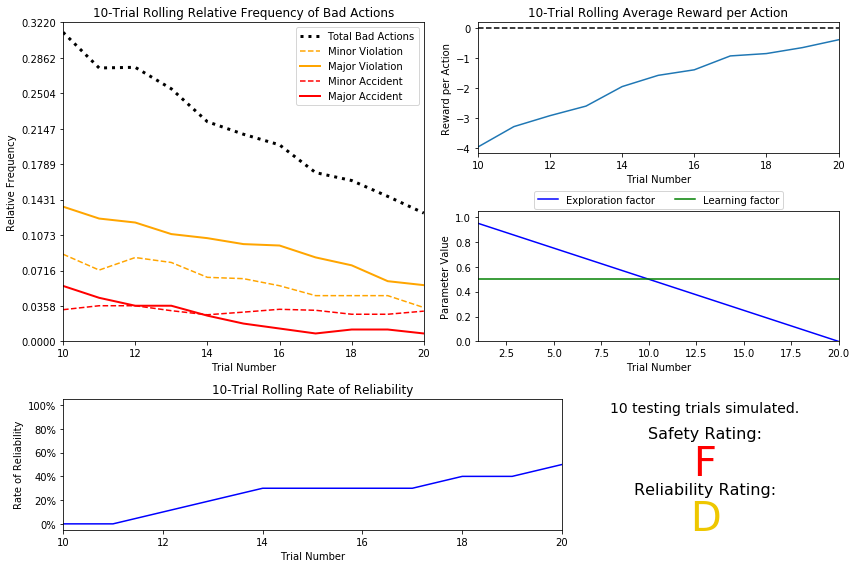

In [5]:
# Load the 'sim_default-learning' file from the default Q-Learning simulation
vs.plot_trials('sim_default-learning.csv')


As the number of training trials increased, the number of bad actions decreases, and the average reward increases. The frequently of the driving agent making bad decisions drops from 30% after 10th trial to around 14% after 20th trial. About 3% of those bad decisions cause major accidents. The agent receives negative rewards for each trial. The similarity between the basic driving agent and default Q-Learning agent is the major accident has the lowest chance to happen. The epsilon decay function in the lower right corner accurately represents the exploration factor. The reliability score is D, which slightly improved compare to the initial driving agent. However, the safety stays at grade F after introduced Q-learning and exploration.  

-----
## Improve the Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to perform the optimization! Now that the Q-Learning algorithm is implemented and the driving agent is successfully learning, it's necessary to tune settings and adjust learning paramaters so the driving agent learns both **safety** and **efficiency**. Typically this step will require a lot of trial and error, as some settings will invariably make the learning worse. One thing to keep in mind is the act of learning itself and the time that this takes: In theory, we could allow the agent to learn for an incredibly long amount of time; however, another goal of Q-Learning is to *transition from experimenting with unlearned behavior to acting on learned behavior*. For example, always allowing the agent to perform a random action during training (if $\epsilon = 1$ and never decays) will certainly make it *learn*, but never let it *act*. When improving on your Q-Learning implementation, consider the implications it creates and whether it is logistically sensible to make a particular adjustment.

### Improved Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.
- `'optimized'` - Set this to `'True'` to tell the driving agent you are performing an optimized version of the Q-Learning implementation.

Additional flags that can be adjusted as part of optimizing the Q-Learning agent:
- `'n_test'` - Set this to some positive number (previously 10) to perform that many testing trials.
- `'alpha'` - Set this to a real number between 0 - 1 to adjust the learning rate of the Q-Learning algorithm.
- `'epsilon'` - Set this to a real number between 0 - 1 to adjust the starting exploration factor of the Q-Learning algorithm.
- `'tolerance'` - set this to some small value larger than 0 (default was 0.05) to set the epsilon threshold for testing.

Furthermore, use a decaying function for $\epsilon$ (the exploration factor). Note that the function **must decay to **`'tolerance'`** at a reasonable rate**. The Q-Learning agent will not begin testing until this occurs. Some example decaying functions (for $t$, the number of trials):

$$ \epsilon = a^t, \textrm{for } 0 < a < 1 \hspace{50px}\epsilon = \frac{1}{t^2}\hspace{50px}\epsilon = e^{-at}, \textrm{for } 0 < a < 1 \hspace{50px} \epsilon = \cos(at), \textrm{for } 0 < a < 1$$
We can also use a decaying function for $\alpha$ (the learning rate) if you so choose, however this is typically less common. If you do so, be sure that it adheres to the inequality $0 \leq \alpha \leq 1$.

Once successfully completed the improved Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

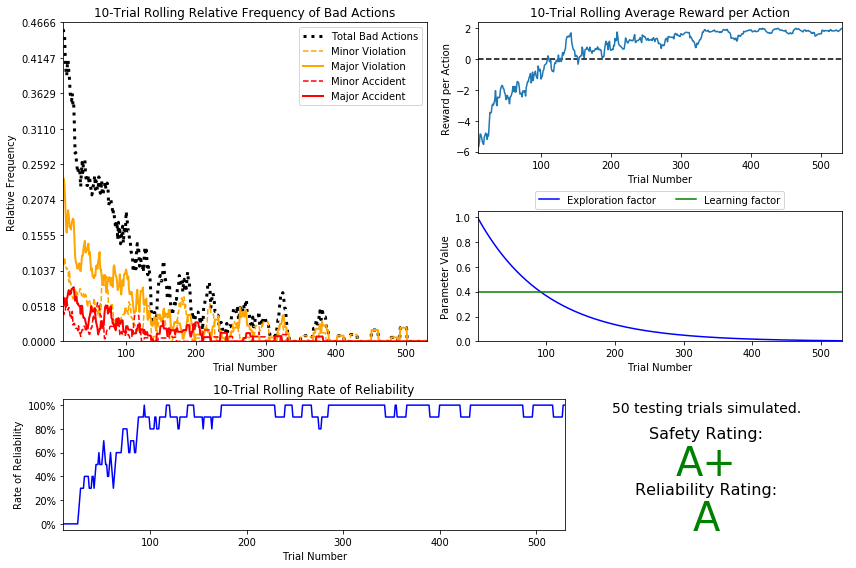

In [16]:
# Load the 'sim_improved-learning' file from the improved Q-Learning simulation
vs.plot_trials('sim_improved-learning.csv')

Decaying function of 0.7**t, 1/t^2, and e**(-0.01*t) are trialed and turns out the exponential decaying function works the best with a completion. Approximatly, 230 training trials are needed for obtaining positive reward on every action. Epsilon tolernce of 0.005 and 0.5 learning rate are used. A constant learning rate 0.5 is picked for average learning speed, the main focus is on the exploration factor epsilon. Since my decaying function works perfect, so this constant is used. A very small, 0.005 epsilon tolerance is used because the agent need to be trained to reach a certainty of carrying out learned to act. The smaller epsilon is, the less random the agent will act in a state. After 300 trials, the accident rate of the agent is nearly to 0% and the safety rate is A+, therefore, the driving agent successfully learned an appropriate policy. 

### Define an Optimal Policy

In this project, I concretely define what it is the agent is trying to learn, and that is the U.S. right-of-way traffic laws. Since these laws are known information, for each state the *Smartcab* is occupying, I can further define the optimal action for the driving agent based on these laws. In that case, we call the set of optimal state-action pairs an **optimal policy**. Hence, unlike some theoretical answers, it is clear whether the agent is acting "incorrectly" not only by the reward (penalty) it receives, but also by pure observation. If the agent drives through a red light, we both see it receive a negative reward but also know that it is not the correct behavior. 

Based on the U.S. right-of-way traffic laws, the agent should comply with the same rule. The defined state =((inputs['light'], inputs['oncoming'],inputs['left'],waypoint))
When the light is red, the agent should act as None unless try to turn right. In this case, it need to check if there is any left vehicle going forward. 
When the light is green, the agent usually moves toward waypoint direction unless turning left when there is oncoming traffic driving forward or try to ture right when the oncoming vehicle turns left. 

Now pulling out sim_improved-learning.txt file and check the state-action to check for optimal policy. 
Starts with 
light      oncoming   left    waypoint
('green', 'forward', 'left', 'right')
 -- forward : 0.00
 -- left : 0.00
 -- right : 0.00
 -- None : -2.07
 when the light is green, the agent tries to turn right. The oncoming traffic at the intersection is forward. The intent direction to the agent's left is turning left, which does not matter at the green light light. The agent should turn right, but it does not necessarily do that as 3 different actions have the same maximum Q-value (0.00), due to the lack of exploration.

('red', None, 'forward', 'right')
 -- forward : -15.69
 -- left : -25.58
 -- right : 0.00
 -- None : 0.39
 When the light is red, and the left intersection traffic is moving forward, in this case, the agent should stay still. The agent pick the right policy since the Q value is max at None. 
 

('green', 'left', None, 'forward')
 -- forward : 1.52
 -- left : -0.13
 -- right : 0.61
 -- None : 0.00
 When the light is green, and the oncoming traffic from the opposite direction is turning left, the intention of the agent is to move forward. In this case, the agent should stay sill. But the Q max at forward, which is not right due to lack of exploration. 
 
 After the agent is trained and explored enought, the last three states are discussed as following. 
 light    oncoming   left    waypoint
 ('green', 'right', 'left', 'left')
 -- forward : 0.20
 -- left : 0.00
 -- right : 0.00
 -- None : -2.91
 When the light is green, the oncoming traffic is turing right, the left / right direction traffic is not matter. The agent should go forward, which is the same in the Q table that forward has the max value. 

('red', 'left', 'left', 'right')
 -- forward : -14.75
 -- left : 0.00
 -- right : 2.16
 -- None : 0.39
 When the light is right, and there is not left traffic going forward, the agent waypoint is right, it should turn right. Predict correctly by Q-max at right. 

('red', 'forward', 'forward', 'left')
 -- forward : -30.92
 -- left : -31.03
 -- right : 0.00
 -- None : 2.10
 When the right is red, and left traffic is moving forward, the agent should stay still no matter the waypoint and oncoming traffic. It predicts correctly. 
 
From the above examples, in example 1 and 3, the agent did not handle green light properly due to lack of exploration, as evidence by 0.0 Q-value. 